In [1]:
import pandas as pd
import numpy as np
# from sklearn.preprocessing import PolynomialFeatures
from sklearn import decomposition
import os
import scipy.stats as sc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import Normalizer
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import to_categorical
from itertools import cycle

# Model Evaluations
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


#Model Graphs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay , RocCurveDisplay
import matplotlib.pyplot as plt

In [2]:
df_co = pd.read_csv('../input/parkinson-disease-detection/Control.csv', index_col = 0)
df_pt = pd.read_csv('../input/parkinson-disease-detection/PD_patient.csv' , index_col = 0)

In [3]:
df_co_len = df_co.shape[0]
df_pt_len = df_pt.shape[0]

In [4]:
df_co_len

1012740

In [5]:
df_pt_len

2304504

In [6]:
df_co_pca = pd.DataFrame(df_co)
df_pt_pca = pd.DataFrame(df_pt)

In [7]:
y1 = pd.Series([0]*df_co_len)
y1.shape

(1012740,)

In [8]:
y2 = pd.Series([1]*df_pt_len, index = range(df_co_len-1,(df_co_len + df_pt_len)-1))
y2.shape

(2304504,)

In [9]:
y = pd.concat([y1,y2]) 
y.shape

(3317244,)

In [10]:
X = pd.concat([df_co_pca, df_pt_pca])

In [11]:
X.shape

(3317244, 18)

In [12]:
y.head(-5)

0          0
1          0
2          0
3          0
4          0
          ..
3317233    1
3317234    1
3317235    1
3317236    1
3317237    1
Length: 3317239, dtype: int64

In [13]:
X_train, X_test, y_train1, y_test1 = train_test_split(X, y, shuffle=True)
y_train = pd.DataFrame(y_train1)
y_test = pd.DataFrame(y_test1)

scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [15]:
model = Sequential()
model.add(LSTM(128,input_dim=18, return_sequences=True)) 
model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.3)) 
model.add(LSTM(64, return_sequences=False))  
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

2022-10-31 15:52:50.388468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 15:52:50.486644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 15:52:50.487503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 15:52:50.489200: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         75264     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 256,386
Trainable params: 256,386
Non-trainable params: 0
__________________________________________________

In [16]:
from tensorflow import keras
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)

In [18]:
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train , test_size= 0.1 , random_state=42)

In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(verbose=1, patience=3)

In [20]:
history = model.fit(X_train, y_train, batch_size=256, epochs=200, validation_data=(X_val, y_val),callbacks=[es])

2022-10-31 15:52:55.035292: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-10-31 15:52:59.668387: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8747/8747 [==============================] - 60s 6ms/step - loss: 0.5333 - accuracy: 0.7396 - val_loss: 0.4890 - val_accuracy: 0.7661
Epoch 2/200
8747/8747 [==============================] - 53s 6ms/step - loss: 0.4600 - accuracy: 0.7823 - val_loss: 0.4095 - val_accuracy: 0.8129
Epoch 3/200
8747/8747 [==============================] - 55s 6ms/step - loss: 0.3779 - accuracy: 0.8300 - val_loss: 0.3112 - val_accuracy: 0.8643
Epoch 4/200
8747/8747 [==============================] - 53s 6ms/step - loss: 0.2999 - accuracy: 0.8700 - val_loss: 0.2274 - val_accuracy: 0.9068
Epoch 5/200
8747/8747 [==============================] - 54s 6ms/step - loss: 0.2458 - accuracy: 0.8969 - val_loss: 0.1795 - val_accuracy: 0.9289
Epoch 6/200
8747/8747 [==============================] - 54s 6ms/step - loss: 0.2114 - accuracy: 0.9137 - val_loss: 0.1500 - val_accuracy: 0.9417
Epoch 7/200
8747/8747 [==============================] - 56s 6ms/step - loss: 0.1890 - accuracy: 0.9239 - val_loss: 0.1293 - val_accurac

In [21]:
model.save_weights("lstm.h5")

In [22]:
from IPython.display import FileLink
FileLink("./lstm.h5")

/kaggle/working/lstm.h5

In [23]:
y_pred = model.predict(X_test)

# For evaluation
y_pred_evaluation = to_categorical(np.argmax(y_pred, axis=1), 2)

# Using it in AUC & Confusion Matrix
y_pred_argmax=(np.argmax(y_pred, axis=1))
y_test_argmax=(np.argmax(y_test, axis=1))

In [24]:
def Evaluate(X_test , y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

In [25]:
def precision(y_test , y_pred, average):
    PrecisionScore = precision_score(y_test, y_pred , average=average) 
    return PrecisionScore

In [26]:
def recall(y_test , y_pred, average):
    RecallScore = recall_score(y_test, y_pred , average=average) 
    return  RecallScore

In [27]:
def F1Score(y_test , y_pred, average):
    F1Score = f1_score(y_test, y_pred , average=average) 
    return F1Score

In [28]:
def AUC(actual_class, pred_class, average = "micro"):
    
    #Making a set of all the unique classes 
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #Making a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [29]:
def plot_roc_curve(y_test,y_pred):
    n_classes=2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw=2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

    plt.plot(fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
           fpr[i],
           tpr[i],
           color=color,
           lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()

In [30]:
def Confusion_Matrix(y_test , y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix )

    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax)
    #disp.plot()
    plt.show()

In [31]:
print("--------- Model Evaluations Details --------- \n")
print(Evaluate(X_test , y_test)) 
print("---------------------------------------------")
print("Micro precision Score is : " , precision(y_test , y_pred_evaluation, "micro"))
print("---------------------------------------------")
print("Micro recall Scores is : " , recall(y_test , y_pred_evaluation, "micro"))
print("---------------------------------------------")
print('Micro F1 Score is : ', F1Score(y_test , y_pred_evaluation, "micro"))
print("---------------------------------------------")
print('AUC Score is : ' , AUC(y_test_argmax, y_pred_argmax))


print("---------------------------------------------")
print("Macro precision, recall, F1 Score : " , precision(y_test , y_pred_evaluation, "macro"), recall(y_test , y_pred_evaluation, "macro"), F1Score(y_test , y_pred_evaluation, "macro"))

--------- Model Evaluations Details --------- 

25916/25916 [==============================] - 87s 3ms/step - loss: 0.0307 - accuracy: 0.9882

Loss: 0.03, Accuracy: 98.82%
None
---------------------------------------------
Micro precision Score is :  0.9882215477667606
---------------------------------------------
Micro recall Scores is :  0.9882215477667606
---------------------------------------------
Micro F1 Score is :  0.9882215477667606
---------------------------------------------
AUC Score is :  {0: 0.9848811645425739, 1: 0.984881164542574}
---------------------------------------------
Macro precision, recall, F1 Score :  0.9873040353075423 0.9848811645425739 0.9860811550929223


Text(0, 0.5, 'Loss')

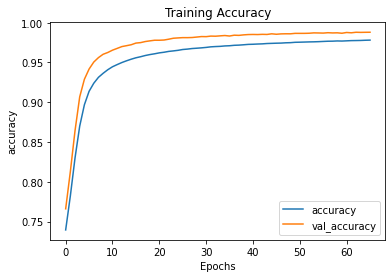

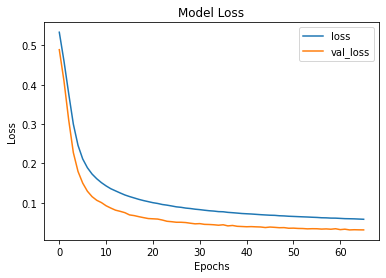

In [32]:
pd.DataFrame(history.history)

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

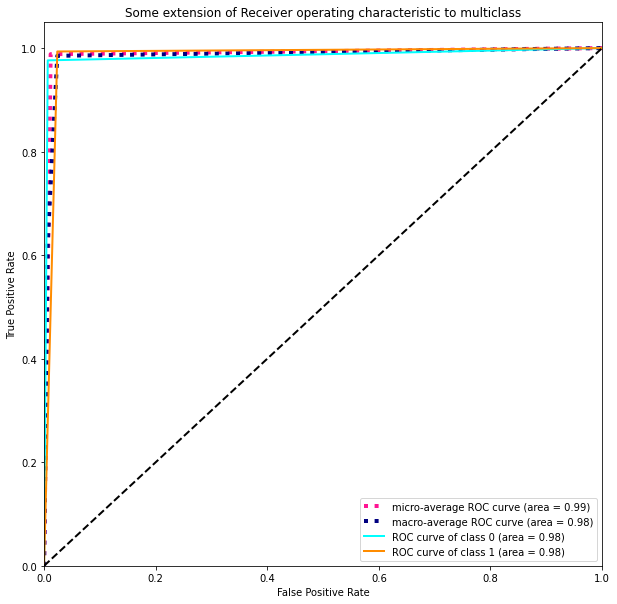

In [33]:
plot_roc_curve(y_test,y_pred_evaluation)

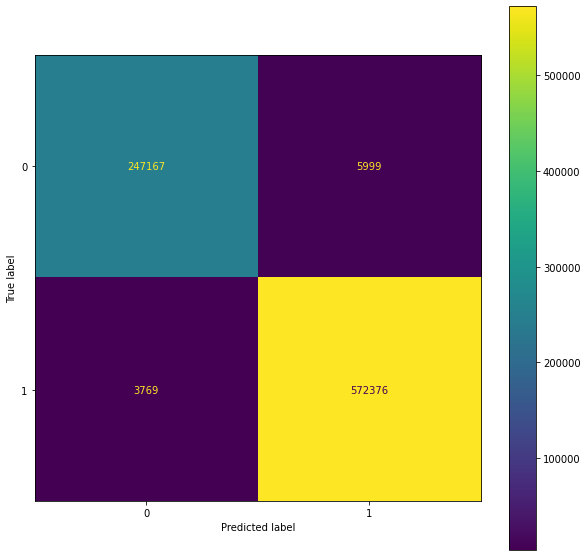

In [34]:
Confusion_Matrix(y_test_argmax , y_pred_argmax)

In [35]:
model.save("parkinson1.h5")
print("saved model")

saved model
